In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from IPython.display import clear_output #
import pandas as pd 

# Modèle Air Berkson 
**Modélisation du risque d'avoir une maladie respiratoire compte tenu de l'exposition au dioxide d'azote ($NO_2$), modélisée par un modèle d'erreur de Berkson**

In [24]:
y = np.array([21,20,15])
n = np.array([48,34,21])
Z = np.array([10,30,50])
#####
data_air = np.zeros((3,3))
data_air[:,0] = y
data_air[:,1] = n
data_air[:,2] = Z

print("------------------ Données Air -----------------------")
print(pd.DataFrame(data_air, columns= ["illness", "nb_group", "NO2"]))
print("--------------------------------------------------")

------------------ Données Air -----------------------
   illness  nb_group   NO2
0     21.0      48.0  10.0
1     20.0      34.0  30.0
2     15.0      21.0  50.0
--------------------------------------------------


On possède trois groupes ayant été exposés à 3 types de concentration différentes de $NO_2$ qu'on résume dans des variables $Z_1, Z_2, Z_3$.  
Pour obtenir les vraies valeurs de concentration dans chaque groupe, on se base sur un modèle d'erreur de mesure de **Berkson** 
$$ X_j = 4.48 + .76 Z_j + \epsilon  \quad j \in \lbrace 1, 2, 3 \rbrace $$ 
où $\epsilon \sim \mathcal{N}(0, 81.14)$

On décompte le nombre d'enfants ayant une maladie respiratoire au sein de chaque groupe et on note la variable associée 
$$ Yj \sim \mathcal{B}in(p_j, n_j) $$
où $n_j$ le nombre d'enfants dans un groupe $j$ et $p_j$ la probabilité d'être atteint d'une maladie respiratoire définie comme suit 
$$ logit(p_j) = \theta_1 + \theta_2 X_j \quad j \in \lbrace 1, 2, 3 \rbrace $$ 

On modélise la dépendance des variables $p_j$ et $X_j$ par une relation affine. On définit une $\mathcal{N}(0, \sigma_1)$ et $\mathcal{N}(0, \sigma_2)$ comme lois a priori pour $\theta_1, \theta_2$, avec $\sigma_{1,2}$  très grand.    
On a donc 5 variables d'interêt au total $X_1, X_2, X_3, \theta_1, \theta_2$.

On effectue dans un premier temps, un MCMC avec échantillonneur de Gibbs sur les 5 lois conditionnelles.

In [5]:
def Gibbs_sampler(nchain, data, init_theta, init_x, sd_theta, sd_x, sigma1, sigma2, tau, burning, lag= 10):
    """_summary_

    Args:
        nchain : taille de l'echantillon simulé
        data : tableau de données
        init_theta : initialisation du MCMC pour les paramètres theta1 et theta2
        init_x : initialisation du MCMC pour les paramètres X1, X2 et X3
        sd_theta : écart-type de la marche aléatoire pour theta1 et theta2
        sd_x : écart-type de la marche aléatoire pour X1, X2 et X3
        sigma1 : variance de la loi a priori de theta1
        sigma2 : variance de la loi a priori de theta1
        tau : variance de la loi a priori des Xj
        burning : simulations non conservées
        lag : Pas d'élagage (Defaults to 10).

    Returns:
        chain_theta, chain_x, probabilité d'acceptation 
    """
    #tableau pour theta 
    theta_chain = np.zeros((nchain+1, 2)) #theta1, theta2
    theta_chain[0] = init_theta
    #tableau pour X
    x_chain = np.zeros((nchain+1,3)) #X1, X2, X3
    x_chain[0] = init_x
    #obs
    y = data[:, 0]
    n = data[:, 1]
    z = data[:, 2]
    alpha = 4.48
    beta = .76
    #paramètre de la moyenne des xi
    mu = alpha + beta * z 
    accep = 0
    
    for i in range(nchain):
        ############### MAJ des Xj ####################@
        #on définit les etaj à partir des dernières MAJ des theta 
        eta = theta_chain[i, 0] + theta_chain[i, 1] * x_chain[i,:] 
        for j in range(3):
            new_candidate = x_chain[i, j] + np.random.normal(scale = sd_x )
            new_etaj = theta_chain[i, 0] + theta_chain[i, 1] * new_candidate 
            top = -((new_candidate - mu[j])**2 / (2*tau)) - y[j] * np.log(1+np.exp(-new_etaj)) + (y[j]-n[j]) * np.log(1+np.exp(new_etaj))
            bottom = -((x_chain[i, j] - mu[j])**2 / (2*tau)) - y[j] * np.log(1+np.exp(-eta[j])) + (y[j]-n[j]) * np.log(1+np.exp(eta[j]))
            ratio = top-bottom
            u = np.log(np.random.uniform())
            if u < ratio:
                x_chain[i+1, j] = new_candidate
                accep+= 1
            else :
                x_chain[i+1, j] = x_chain[i, j]
                
        ################ MAJ theta 1 #####################
        new_candidate = theta_chain[i, 0] + np.random.normal(scale = sd_theta[0])
        new_eta = new_candidate + theta_chain[i, 1] * x_chain[i+1, :] #vecteur de 3
        eta = theta_chain[i, 0] + theta_chain[i, 1] * x_chain[i+1, :]
        top = -(new_candidate**2/(2*sigma1)) - (y* np.log(1+np.exp(-new_eta))).sum() + ((y-n) * np.log(1+np.exp(new_eta))).sum() # - (n-y) pour la formule
        bottom = -(theta_chain[i, 0]**2/(2*sigma1)) - (y* np.log(1+np.exp(-eta))).sum() + ((y-n) * np.log(1+np.exp(eta))).sum()
        ratio = top - bottom
        u = np.log(np.random.uniform())
        if u < ratio:
            theta_chain[i+1, 0] = new_candidate
            accep += 1
        else :
            theta_chain[i+1, 0] = theta_chain[i, 0]
        
        #################### MAJ theta 2 ############## 
        new_candidate = theta_chain[i, 1] + np.random.normal(scale = sd_theta[1])
        ####
        new_eta = theta_chain[i+1, 0] + new_candidate * x_chain[i+1,:] #on part de la dernière MAJ de theta1
        eta = theta_chain[i+1, 0] + theta_chain[i, 1] * x_chain[i+1, :] #on passe à +1 pour le theta2 car MAJ coord par coord 
        ######
        top = -(new_candidate**2/(2*sigma2)) - (y* np.log(1+np.exp(-new_eta))).sum() + ((y-n) * np.log(1+np.exp(new_eta))).sum()
        bottom = -(theta_chain[i, 1]**2/(2*sigma2)) - (y* np.log(1+np.exp(-eta))).sum() + ((y-n) * np.log(1+np.exp(eta))).sum()
        ratio = top - bottom
        u = np.log(np.random.uniform())
        if u < ratio:
            theta_chain[i+1, 1] = new_candidate
            accep +=1
        else :
            theta_chain[i+1, 1] = theta_chain[i, 1]
        
        
        if i % 100 == 0:
            clear_output(wait = True)
            print(f"Iteration : {i}")
            
    #processing the simulation with burning period and lag 
    theta_chain = theta_chain[burning: , :]
    x_chain = x_chain[burning:, ]
    
    vector_lag = np.arange(0, (nchain-burning), lag)
    return theta_chain[vector_lag ,:], x_chain[vector_lag, :], accep/(5*nchain)
      
        
    

In [6]:
?Gibbs_sampler

Signature:
Gibbs_sampler(
    nchain,
    data,
    init_theta,
    init_x,
    sd_theta,
    sd_x,
    sigma1,
    sigma2,
    tau,
    burning,
    lag=10,
)
Docstring:
_summary_

Args:
    nchain : taille de l'echantillon simulé
    data : tableau de données
    init_theta : initialisation du MCMC pour les paramètres theta1 et theta2
    init_x : initialisation du MCMC pour les paramètres X1, X2 et X3
    sd_theta : écart-type de la marche aléatoire pour theta1 et theta2
    sd_x : écart-type de la marche aléatoire pour X1, X2 et X3
    sigma1 : variance de la loi a priori de theta1
    sigma2 : variance de la loi a priori de theta1
    tau : variance de la loi a priori des Xj
    burning : simulations non conservées
    lag : Pas d'élagage (Defaults to 10).

Returns:
    chain_theta, chain_x, probabilité d'acceptation 
File:      c:\users\matth\appdata\local\temp\ipykernel_11652\2320586428.py
Type:      function

In [12]:
#hyperparm 
tau2 = 81.14 #variance pour les Xj (dans le papier)
sigma1 = 1000 #variance pour theta1
sigma2 = 1000 #variance pour theta2
prop_sdx = 5 #pas du noyau de proposition pour les Xi
sd_theta1 = 1 #pas du noyau de proposition pour theta1
sd_theta2 = .01 #pas du noyau de proposition pour theta2

theta, X, prob_accep = Gibbs_sampler(11000, data_air, np.array([0, 0]), np.zeros(3), np.array([sd_theta1, sd_theta2]), prop_sdx, sigma1, sigma2, tau2, 1000,5)

Iteration : 10900


In [13]:
print(f"Probabilité d'acceptation {round(prob_accep,2)} ")

Probabilité d'acceptation 0.64 


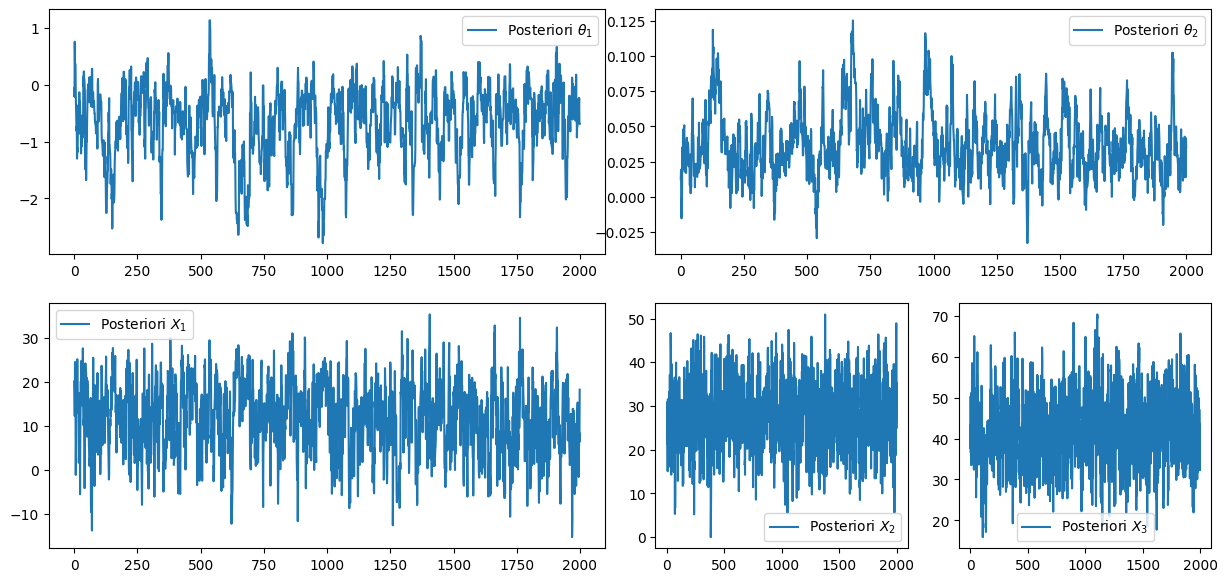

In [14]:
fig, ax = plt.subplot_mosaic([["A","A", "B","B"], ["C","C", "D", "F"]], figsize = (15, 7))

ax["A"].plot(theta[:, 0], label= r"Posteriori $\theta_1$")
ax["A"].legend()
ax["B"].plot(theta[:, 1], label= r"Posteriori $\theta_2$")
ax["B"].legend()
ax["C"].plot(X[:, 0], label = r"Posteriori $X_1$")
ax["C"].legend()
ax["D"].plot(X[:, 1], label= r"Posteriori $X_2$")
ax["D"].legend()
ax["F"].plot(X[:, 2], label= r"Posteriori $X_3$")
ax["F"].legend()

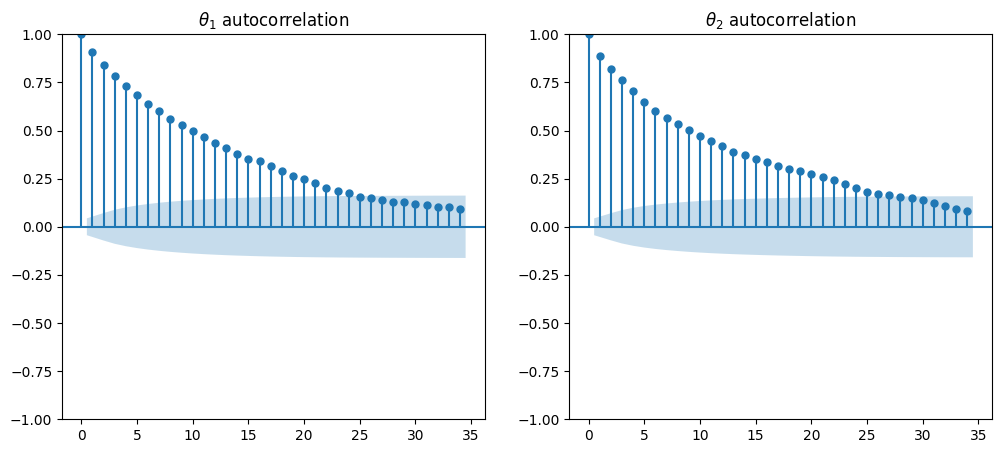

In [108]:
from statsmodels.graphics import tsaplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))
tsaplots.plot_acf(theta[:, 0], ax=ax1, title= r"$\theta_1$ autocorrelation");
tsaplots.plot_acf(theta[:, 1], ax=ax2, title= r"$\theta_2$ autocorrelation");

**Autocorrélations importantes pour les paramètres $\theta_1$ et $\theta_2$.**

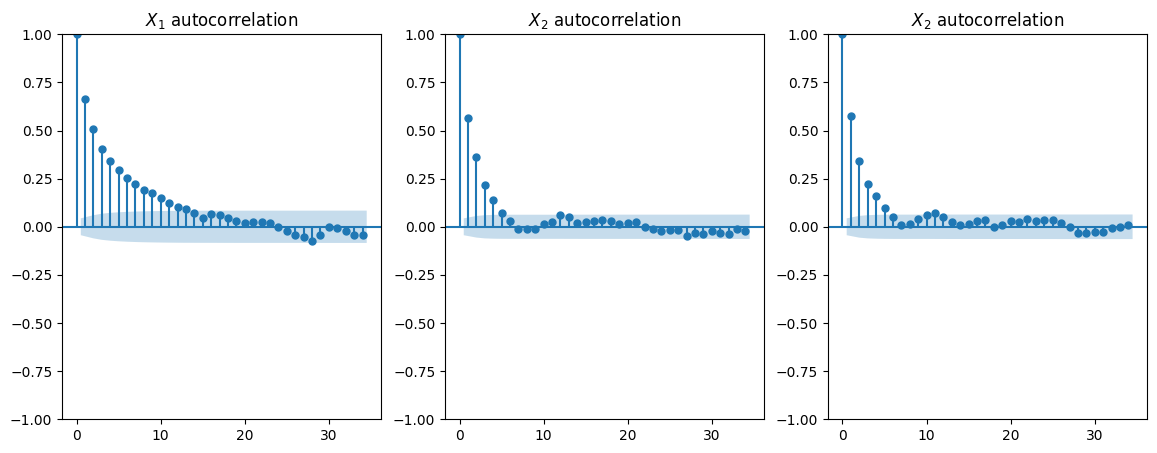

In [110]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (14,5))
tsaplots.plot_acf(X[:, 0], ax=ax1, title= r"$X_1$ autocorrelation");
tsaplots.plot_acf(X[:, 1], ax=ax2, title= r"$X_2$ autocorrelation");
tsaplots.plot_acf(X[:, 2], ax=ax3, title= r"$X_2$ autocorrelation");

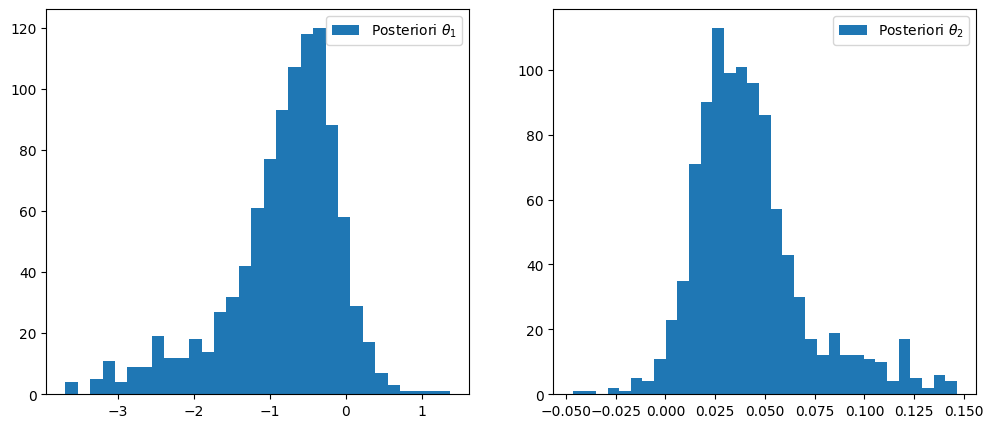

In [103]:
fig, ax = plt.subplot_mosaic([["A","B"]], figsize = (12, 5))
ax["A"].hist(theta[: , 0], bins = "auto", label = r"Posteriori $\theta_1$")
ax["A"].legend()
ax["B"].hist(theta[: , 1], bins = "auto", label = r"Posteriori $\theta_2$")
ax["B"].legend()

In [15]:
#Tableau résumé : statistiques des différents paramètres ?
print("-------------------------------------------------------------------------------")
print(f"Estimateur en moyenne de theta1 {round(np.mean(theta[: , 0]), 2)} et variance de la loi a posteriori {round(np.std(theta[: , 0]), 2)}")
print(f"Estimateur en moyenne de theta2 {round(np.mean(theta[: , 1]),2)} et variance de la loi a posteriori {round(np.std(theta[: , 1]),2)}")
print(f"Estimateur en moyenne de X1 {round(np.mean(X[: , 0]),2)} et variance de la loi a posteriori {round(np.std(X[: , 0]),2)}")
print(f"Estimateur en moyenne de X2 {round(np.mean(X[: , 1]),2)} et variance de la loi a posteriori {round(np.std(X[: , 1]),2)}")
print(f"Estimateur en moyenne de X3 {round(np.mean(X[: , 2]),2)} et variance de la loi a posteriori {round(np.std(X[: , 2]),2)}")

-------------------------------------------------------------------------------
Estimateur en moyenne de theta1 -0.66 et variance de la loi a posteriori 0.62
Estimateur en moyenne de theta2 0.04 et variance de la loi a posteriori 0.02
Estimateur en moyenne de X1 11.53 et variance de la loi a posteriori 8.08
Estimateur en moyenne de X2 27.68 et variance de la loi a posteriori 7.53
Estimateur en moyenne de X3 41.92 et variance de la loi a posteriori 8.54


## Centrage des variables $X_j$ dans l'expression des probabilités $p_j$   

Il y a énormement de dépendance dans les chaines simulées, pour réduire cela, on change l'expression de $p_j$.
$$ logit(p_j) = \tilde{\theta_1} + \tilde{\theta_2} (X_j - \overline{\mu}), \quad \overline{\mu}= \frac{1}{3} \sum_{i=1}^3 \mu_j $$

On a donc $\theta_2 = \tilde{\theta_2}$ et  $\quad \theta_1 = \tilde{\theta_1}  - \theta_2 * \overline{\mu}$. 

On rappelle que les $\theta_1$, $\theta_2$ sont valables pour les 3 groupes d'exposition. En l'occurence ce pseudo-centrage permet d'apporter une information provenant de ces 3 groupes. On réduit ainsi la dépendance entre $\theta_{1,2}$ et le groupe considéré. 

In [7]:
def Gibbs_sampler_centered(nchain, data, init_theta, init_x, sd_theta, sd_x, sigma1, sigma2, tau, burning, lag= 10):
    #tableau pour theta 
    theta_chain = np.zeros((nchain+1, 2)) #theta1, theta2
    theta_chain[0] = init_theta
    #tableau pour X
    x_chain = np.zeros((nchain+1,3)) #X1, X2, X3
    x_chain[0] = init_x
    #obs
    y = data[:, 0]
    n = data[:, 1]
    z = data[:, 2]
    alpha = 4.48
    beta = .76
    #paramètre de la moyenne des xi
    mu = alpha + beta * z 
    accep = 0
    
    #centered Xj
    mu_bar = mu.mean()
    
    for i in range(nchain):
        ############### MAJ des Xj ####################@
        #on définit les etaj à partir des dernières MAJ des theta 
        eta = theta_chain[i, 0] + theta_chain[i, 1] * (x_chain[i,:] - mu_bar)
        for j in range(3):
            new_candidate = x_chain[i, j] + np.random.normal(scale = sd_x )
            new_etaj = theta_chain[i, 0] + theta_chain[i, 1] * (new_candidate -mu_bar)
            top = -((new_candidate - mu[j])**2 / (2*tau)) - y[j] * np.log(1+np.exp(-new_etaj)) + (y[j]-n[j]) * np.log(1+np.exp(new_etaj))
            bottom = -((x_chain[i, j] - mu[j])**2 / (2*tau)) - y[j] * np.log(1+np.exp(-eta[j])) + (y[j]-n[j]) * np.log(1+np.exp(eta[j]))
            ratio = top-bottom
            u = np.log(np.random.uniform())
            if u < ratio:
                x_chain[i+1, j] = new_candidate
                accep+= 1
            else :
                x_chain[i+1, j] = x_chain[i, j]
        
        ################ MAJ theta 1 #####################
        new_candidate = theta_chain[i, 0] + np.random.normal(scale = sd_theta[0])
        new_eta = new_candidate + theta_chain[i, 1] * (x_chain[i+1, :]- mu_bar) #vecteur de 3
        eta = theta_chain[i, 0] + theta_chain[i, 1] * (x_chain[i+1, :]- mu_bar)
        top = -(new_candidate**2/(2*sigma1)) - (y* np.log(1+np.exp(-new_eta))).sum() + ((y-n) * np.log(1+np.exp(new_eta))).sum()
        bottom = -(theta_chain[i, 0]**2/(2*sigma1)) - (y* np.log(1+np.exp(-eta))).sum() + ((y-n) * np.log(1+np.exp(eta))).sum()
        ratio = top - bottom
        u = np.log(np.random.uniform())
        if u < ratio:
            theta_chain[i+1, 0] = new_candidate
            accep += 1
        else :
            theta_chain[i+1, 0] = theta_chain[i, 0]
        
        #################### MAJ theta 2 ############## 
        new_candidate = theta_chain[i, 1] + np.random.normal(scale = sd_theta[1])
        ####
        new_eta = theta_chain[i+1, 0] + new_candidate * (x_chain[i+1,:]-mu_bar) #on part de la dernière MAJ de theta1
        eta = theta_chain[i+1, 0] + theta_chain[i, 1] *( x_chain[i+1, :]- mu_bar) #on passe à +1 pour le theta2 car MAJ coord par coord 
        ######
        top = -(new_candidate**2/(2*sigma2)) - (y* np.log(1+np.exp(-new_eta))).sum() + ((y-n) * np.log(1+np.exp(new_eta))).sum()
        bottom = -(theta_chain[i, 1]**2/(2*sigma2)) - (y* np.log(1+np.exp(-eta))).sum() + ((y-n) * np.log(1+np.exp(eta))).sum()
        ratio = top - bottom
        u = np.log(np.random.uniform())
        if u < ratio:
            theta_chain[i+1, 1] = new_candidate
            accep +=1
        else :
            theta_chain[i+1, 1] = theta_chain[i, 1]
        
        
        if i % 1000 == 0:
            clear_output(wait = True)
            print(f"Iteration : {i}")
    
    #processing the simulation with burning period and lag 
    vec = np.arange(burning, nchain+1, lag)
    
    theta_chain[:, 0] = theta_chain[:, 0] - mu_bar * theta_chain[:, 1]
    return theta_chain[vec ,:], x_chain[vec, :], accep/(5*nchain)
      
        
    

On trace 3 chaînes avec des valeurs d'initialisations perturbées par une gaussienne de faible variance. Le but est de voir s'il y a convegence.

Iteration : 30000


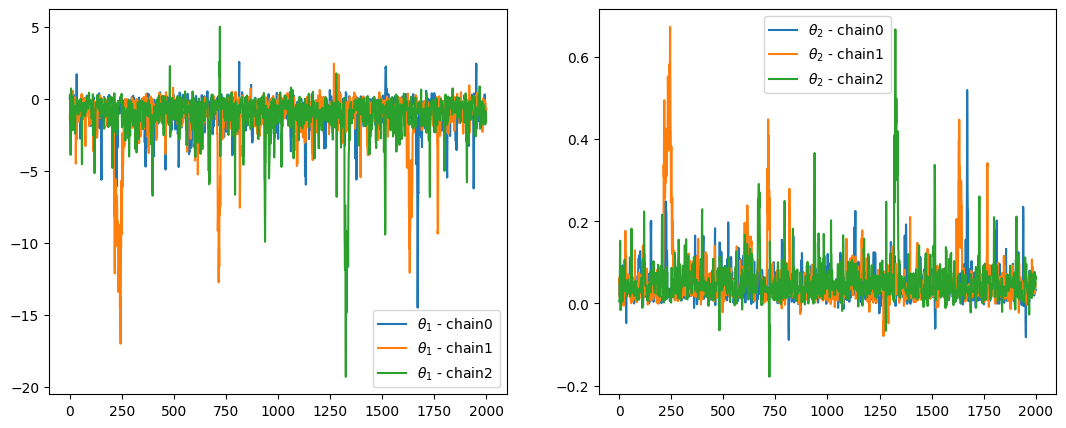

In [81]:
#hyperparm 
tau2 = 81.14 #variance pour les Xj (dans le papier)
sigma1 = 500 #variance pour theta1  (1000) ou (500)
sigma2 = 500 #variance pour theta2  (1000) ou (500)
prop_sdx = 12 #pas du noyau de proposition pour les Xi (10) ou (12)
sd_theta1 = 6 #pas du noyau de proposition pour theta1  (5) ou (6)
sd_theta2 = .1 #pas du noyau de proposition pour theta2 (.05) ou (.1)

fig, ax = plt.subplots(1,2, figsize = (13,5))
for i in range(3):
    theta_centered, _, _ = Gibbs_sampler_centered(31000, data_air, np.array([0, 0]) + np.random.normal(size=(1,2), scale= .5), 
                                                       np.zeros(3) + np.random.normal(size=(1,3), scale= .5), 
                                                       np.array([sd_theta1, sd_theta2]), prop_sdx, sigma1, sigma2, tau2, 21000, 5);
    ax[0].plot(theta_centered[:, 0], label = r'$\theta_1$ - chain%d '%i);
    ax[1].plot(theta_centered[:, 1], label = r'$\theta_2$ - chain%d '%i);
ax[0].legend()
ax[1].legend()

Les chaines se superposent toutes, on peut considérer les paramètres fixés ci-dessus avec une simulation de taille 31 000 et un burning de 21 000

In [90]:
theta_centered, X_centered, prob_accep = Gibbs_sampler_centered(31000, data_air, np.array([0, 0]), 
                                                        np.zeros(3), np.array([sd_theta1, sd_theta2]), prop_sdx, sigma1, sigma2, tau2, 21000, 5)

Iteration : 30000


> Deux paramètrages efficaces : 

- variances des lois a priori 1000, 1000 et sd_prop 10, 5, .05 (corrélations plus importantes pour les theta; probabilité d'acceptation de .42)  
- variances des lois a priori 500, 500 et sd_prop 12, 6, .1 (corrélations plus faibles mais variances plus importantes, probabilité d'acceptation de .36)


In [91]:
prob_accep

0.33648387096774196

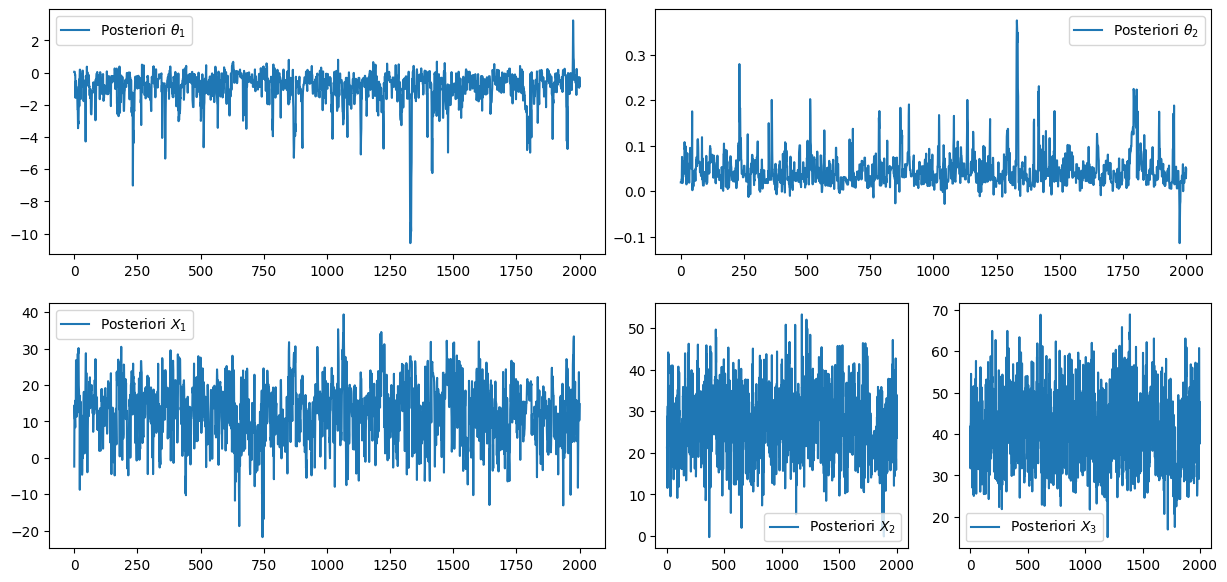

In [92]:
fig, ax = plt.subplot_mosaic([["A","A", "B","B"], ["C","C", "D", "F"]], figsize = (15, 7))

ax["A"].plot(theta_centered[:, 0], label= r"Posteriori $\theta_1$")
ax["A"].legend()
ax["B"].plot(theta_centered[:, 1], label= r"Posteriori $\theta_2$")
ax["B"].legend()
ax["C"].plot(X_centered[:, 0], label = r"Posteriori $X_1$")
ax["C"].legend()
ax["D"].plot(X_centered[:, 1], label= r"Posteriori $X_2$")
ax["D"].legend()
ax["F"].plot(X_centered[:, 2], label= r"Posteriori $X_3$")
ax["F"].legend()

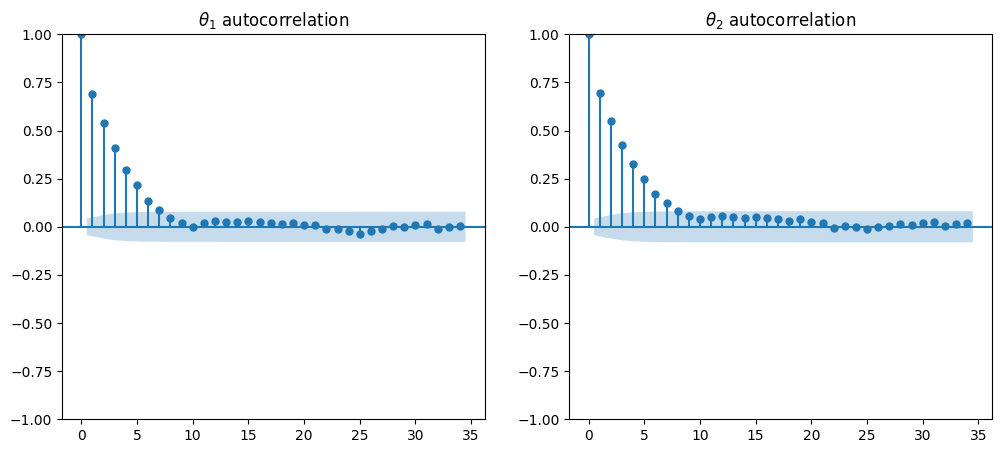

In [93]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))
autocorr_theta1 = tsaplots.plot_acf(theta_centered[:, 0], ax=ax1, title= r"$\theta_1$ autocorrelation")
autocorr_theta2 = tsaplots.plot_acf(theta_centered[:, 1], ax=ax2, title= r"$\theta_2$ autocorrelation")

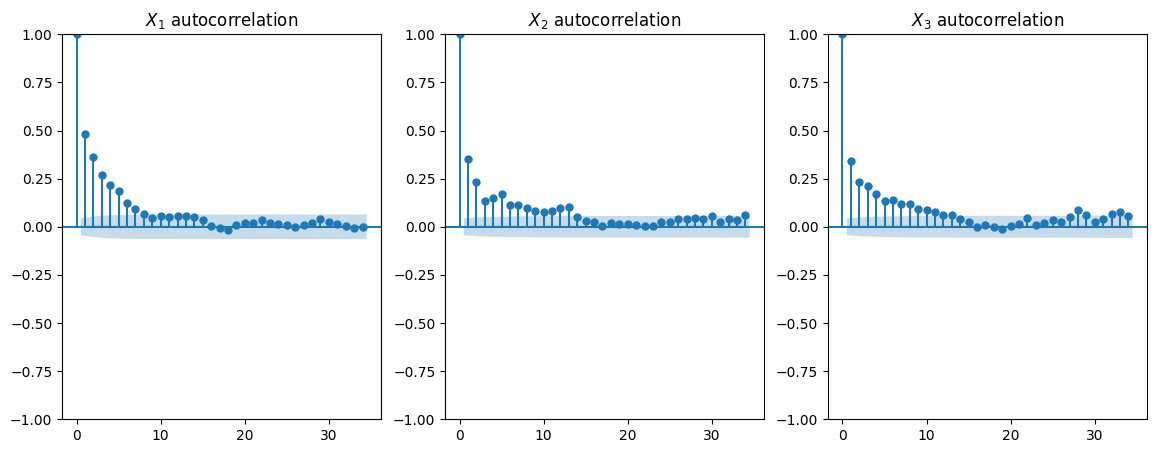

In [94]:
fig, ax = plt.subplots(1,3, figsize = (14, 5))
autocorr_X1 = tsaplots.plot_acf(X_centered[:, 0], ax = ax[0], title= r"$X_1$ autocorrelation")
autocorr_X2 = tsaplots.plot_acf(X_centered[:, 1], ax = ax[1], title= r"$X_2$ autocorrelation")
autocorr_X3 = tsaplots.plot_acf(X_centered[:, 2], ax = ax[2], title= r"$X_3$ autocorrelation")

In [95]:
#Tableau résumé : statistiques des différents paramètres ?
print("-------------------------------------------------------------------------------")
print(f"Estimateur en moyenne de theta1 {round(np.mean(theta_centered[: , 0]), 2)} et variance de la loi a posteriori {round(np.std(theta_centered[: , 0]), 2)}")
print(f"Estimateur en moyenne de theta2 {round(np.mean(theta_centered[: , 1]),2)} et variance de la loi a posteriori {round(np.std(theta_centered[: , 1]),2)}")
print(f"Estimateur en moyenne de X1 {round(np.mean(X_centered[: , 0]),2)} et variance de la loi a posteriori {round(np.std(X_centered[: , 0]),2)}")
print(f"Estimateur en moyenne de X2 {round(np.mean(X_centered[: , 1]),2)} et variance de la loi a posteriori {round(np.std(X_centered[: , 1]),2)}")
print(f"Estimateur en moyenne de X3 {round(np.mean(X_centered[: , 2]),2)} et variance de la loi a posteriori {round(np.std(X_centered[: , 2]),2)}")
print("----------------------------------------------------------")


-------------------------------------------------------------------------------
Estimateur en moyenne de theta1 -0.9 et variance de la loi a posteriori 1.03
Estimateur en moyenne de theta2 0.05 et variance de la loi a posteriori 0.04
Estimateur en moyenne de X1 12.58 et variance de la loi a posteriori 8.16
Estimateur en moyenne de X2 27.37 et variance de la loi a posteriori 7.36
Estimateur en moyenne de X3 41.16 et variance de la loi a posteriori 8.2
----------------------------------------------------------


In [96]:
p = 1/ (1+np.exp(-(theta_centered[:, 0] + theta_centered[:, 1] * X_centered.T)))
print("-------------------------------------------------------------------------------")
print(f"Estimateur en moyenne de p1 {round(np.mean(p[0, :]), 2)} et variance de la loi a posteriori {round(np.std(p[0, :]), 2)}")
print(f"Estimateur en moyenne de p2 {round(np.mean(p[1, :]), 2)} et variance de la loi a posteriori {round(np.std(p[1, :]), 2)}")
print(f"Estimateur en moyenne de p3 {round(np.mean(p[2, :]), 2)} et variance de la loi a posteriori {round(np.std(p[2, :]), 2)}")

-------------------------------------------------------------------------------
Estimateur en moyenne de p1 0.45 et variance de la loi a posteriori 0.07
Estimateur en moyenne de p2 0.59 et variance de la loi a posteriori 0.07
Estimateur en moyenne de p3 0.7 et variance de la loi a posteriori 0.09


On remarque que la probabilité d'avoir une maladie respiratoire augmente avec la concentration de dioxyde d'azote (NO2), donc plus on est exposé au $NO_2$ plus on a de chance d'être atteint d'une maladie respiratoire. 

> Visualisation des distributions à posteriori 

In [97]:
import scipy.stats as stats
theta1_density = stats.gaussian_kde(theta_centered[: , 0])
theta2_density = stats.gaussian_kde(theta_centered[: , 1])

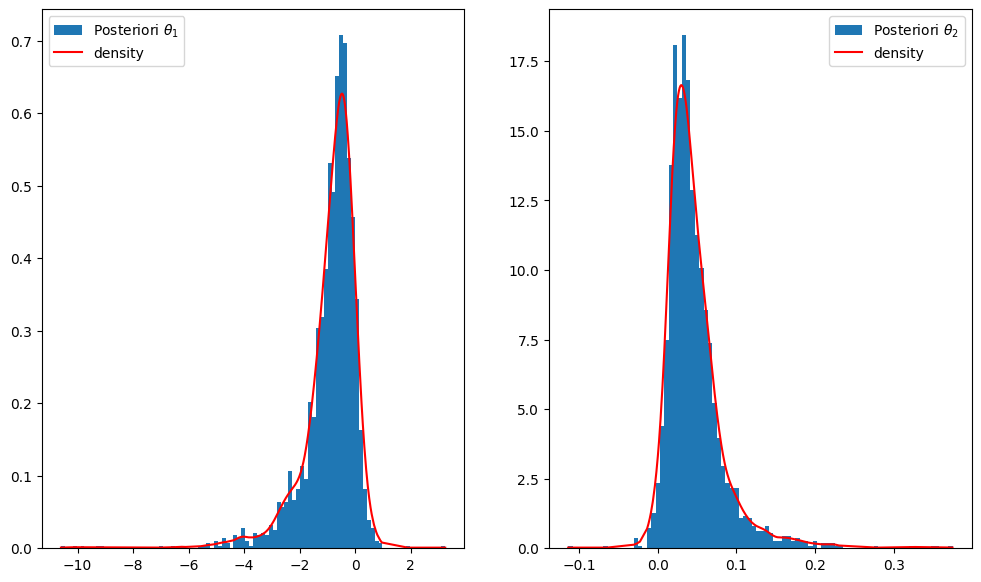

In [98]:
fig, ax = plt.subplot_mosaic([["A","B"]], figsize = (12, 7))
ax["A"].hist(theta_centered[: , 0], bins = "auto", label = r"Posteriori $\theta_1$", density = True)
ax["A"].plot(np.sort(theta_centered[:, 0]), theta1_density(np.sort(theta_centered[:, 0])), color = 'red', label = "density")
ax["A"].legend()
ax["B"].hist(theta_centered[: , 1], bins = "auto", label = r"Posteriori $\theta_2$", density = True)
ax["B"].plot(np.sort(theta_centered[:, 1]), theta2_density(np.sort(theta_centered[:, 1])), color = 'red', label = "density")
ax["B"].legend()

On remarque, (tout comme la trajectoire des chaînes) qu'il y a une symétrie entre $\theta_1$ et $\theta_2$.

Le paramètre $\theta_1$, vu comme l'ordonnée à l'origine, illustre la probabilité d'avoir une maladie respiratoire sans facteur de risque tandis que $\theta_2$ modélise l'augmentation de cette probabilité en fonction de l'exposition.